In [14]:
using CSV
using DataFrames

using LinearAlgebra
using LabelledArrays
using DifferentialEquations

using AlgebraicDynamics
using AlgebraicDynamics.DWDDynam

using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz

using Plots
using LaTeXStrings

<img src="windkaart_nl_v10.jpg" alt="Drawing" style="width: 600px;" align="right"/>

In this exercise we are going to consider the social, economical, and technical aspects of the off-shore wind park projects planned in the Netherlands. Other system dynamic models (SDM) that have been studying the energy sector are [3, 11, 12].

### I) Difference in Focus
In [11] the focus in on the large-scale dynamics of a sustainable energy transition (SET) and especially on quantifying the energy investment required to complete a SET, throught the lens of system dynamic modelling using [AnyLogic](https://www.anylogic.com/blog/we-are-shutting-down-runthemodel-com/) [AnyLogic](https://www.anylogic.com/blog/we-are-shutting-down-runthemodel-com/). In order to rigorously define the constraints of SET, they introduce a theoretical energy economy framework along with the concept of the renewable energy investment ratio (epsilon, i.e., the ratio of energy invested in renewable energy generation over the total primary available energy).

### II) Difference in Code Implementation
Traditionally, SDMs are based on programming languages like [STELLAS](https://en.wikipedia.org/wiki/STELLA_(programming_language)), [Vensim](https://en.wikipedia.org/wiki/Vensim), [Powersim](https://en.wikipedia.org/wiki/PSIM_Softwarehttps://en.wikipedia.org/wiki/PSIM_Software) ([AnyLogic](https://www.anylogic.com/blog/we-are-shutting-down-runthemodel-com/) shut down in 2017) etc. All of them are commercial (with the exception that Vensim has a free educational version). Vensim, which might be the most used simulation software of the three, and the support system were ported to the C language. Vensim can be linked with other programming languages, including C, C++, Visual Basic, Delphi, and others. In contrast, modelling tools generally obscure the distinction between syntax and semantics. These blurred lines make it challenging to interoperate between modelling frameworks and to independently adjust model syntax and model semantics [[13]](http://arxiv.org/abs/2105.12282).


### III)The Dutch Case

The most important parts in this scenario are taken by the wind turbines, financial investments, and the public.

The dutch offshore wind park plans are visualised in the image to the right.

The wind turbines will be spaced 1km appart [1]. De turbines die vanaf 2020 in het windenergiegebied Borssele staan, hebben al een vermogen van 8 tot 9.5 MW per stuk [2]

Het energieverbruik per inwoner is tussen 2000 en 2016 met 18 procent gedaald, van 32.2 GJ naar 26.4 GJ [3].

#### III.I) Dynamics Hypothesis 


# 0. Load Data

In [15]:
# Energy production by off-shore wind parks in the Netherlands
# source: https://opendata.cbs.nl/statline/#/CBS/en/dataset/82610ENG/table?ts=1636732866920

df_energy = DataFrame(CSV.File("/home/christovis/PostDoc/PACES/data/Electricity_wind_offshore_11112021_134459.csv"));
dropmissing!(df_energy);
rename!(
    df_energy,
    ["Installed installations/Electrical capacity end of year (megawatt)" => "capacity_in_operation",]
);
df_energy.Periods = map(x -> parse(Int64, match(r"[[:digit:]]+", x).match), df_energy.Periods);
# convert MWh to Wh
df_energy.capacity_in_operation *= 1e6;

# 1. Simple Power Security Model

**Stock Flows:** Population, Energy Capacity

TODO: what would the difference be to simply using a delay differential?

<img src="EnrgySys_WindFarm_medium.drawio.png" alt="Drawing" style="width: 800px;"/>

### 1.1 Definition of terminology 

**Electrical capacity end of year:** Electrical capacity is the amount of electricity that can be generated per unit of time during normal use of all available installations that produce electricity.


### 1.2 Description
We do not couple the **capacity_in_operation** to **increase_rate** as we assume that the population is happy with energy as is.

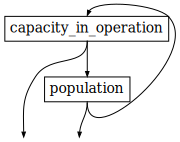

In [3]:
DWD_OffshoreWindEnergy = WiringDiagram(
    [], [:capacity_in_operation, :population],
)

box_cio = add_box!(DWD_OffshoreWindEnergy, Box(:capacity_in_operation, [:pop], [:wh]))
box_pop = add_box!(DWD_OffshoreWindEnergy, Box(:population, [:wh], [:pop]))

box_in = input_id(DWD_OffshoreWindEnergy)
box_out = output_id(DWD_OffshoreWindEnergy)
add_wires!(DWD_OffshoreWindEnergy, Pair[        
    # internal
    (box_cio, 1) => (box_pop, 1),
    (box_pop, 1) => (box_cio, 1),

    # net output
    (box_cio, 1) => (box_out, 1),
    (box_pop, 1) => (box_out, 2),
])

to_graphviz(DWD_OffshoreWindEnergy)

In [4]:
dt_cio = function(u, x, p, t)
    # Stock
    capacity_in_operation = u[1]  #[Wh]
    # Exogenous variables
    population = x[1]
    # Flow
    energy_demand = population * p.energy_per_citizen  #[Wh]
    energy_security = capacity_in_operation / energy_demand - 1
    increase_rate_needed = energy_security > 0 ? p.enesec_impact_on_cio.surplus : p.enesec_impact_on_cio.shortfall  #[-]
    increase_rate_possible = max( (p.energy_of_total_area - capacity_in_operation) / p.construction_delay, 0)  #[d(Wh)/dt]
    increase_rate = increase_rate_needed * increase_rate_possible  #[d(Wh)/dt]
    loss_rate = capacity_in_operation / p.life_expectancy_of_turbine  #[d(Wh)/dt]
    return [increase_rate - loss_rate]
end;

dt_population = function(u, x, p, t)
    # Stock
    population = u[1]  #[-]
    # Exogenous variables
    capacity_in_operation = x[1]
    # Flow
    energy_demand = population * p.energy_per_citizen  #[Wh]
    energy_security = capacity_in_operation / energy_demand - 1  #[-]
    energy_security_impact = energy_security > 0 ? p.enesec_impact_on_pop.surplus : p.enesec_impact_on_pop.shortfall  #[-]
    birth_rate = population * p.birth_fraction * energy_security_impact #[d/dt]
    death_rate = population / p.life_expectancy_of_human  #[d/dt]
    return [birth_rate - death_rate]
end;

machine_cio = ContinuousMachine{Float64}(1,1,1, dt_cio, (u, p, t)->u)
machine_population = ContinuousMachine{Float64}(1,1,1, dt_population, (u, p, t)->u)

Model_OffshoreWindEnergy = oapply(
    DWD_OffshoreWindEnergy,
    Dict(
        :capacity_in_operation => machine_cio,
        :population => machine_population,
    )
)

ContinuousMachine(ℝ^2 × ℝ^0 → ℝ^2)

In [5]:
energy_of_each_area = LVector(  # [2]
    Borssele = (731.5 + 752 + 19) * 1e6,  #[Wh]
    HollandseKust_zuid = (129 + 760 + 760) * 1e6,  #[Wh]
    HollandseKust_noord = (759 + 120 + 108) * 1e6,  #[Wh]
    HollandseKust_west = 1400 * 1e6,  #[Wh]
    IjmuidenVer = 4000 * 1e6,  #[Wh]
    Waddeneilanden = 700 * 1e6,  #[Wh]
)

params = LVector(
    energy_per_turbine=9.5*1e6*60^2,  #[Wh] [2]
    energy_of_total_area=sum(energy_of_each_area),  #[Wh]
    enesec_impact_on_cio=LVector(surplus=0.0, shortfall=1.5),  #[-]
    enesec_impact_on_pop=LVector(surplus=2.0, shortfall=0.0),  #[-]
    life_expectancy_of_turbine=20,  #[yr]=20
    construction_delay=2,  #[yr] [3]=2
    life_expectancy_of_human=81,  #[yr] [6]=81
    birth_fraction=0.028,  #[%] [7]=0.0098
    energy_per_citizen=1070*1e3/(365*24),  #[Wh] [8]
);

In [6]:
u0 = [df_energy.capacity_in_operation[1], 16.35*1e6];  # [energy, population] at 2006
tspan = (0.0, 100.0);

prob = ODEProblem(Model_OffshoreWindEnergy, u0, tspan, params);
sol = solve(prob, Tsit5());

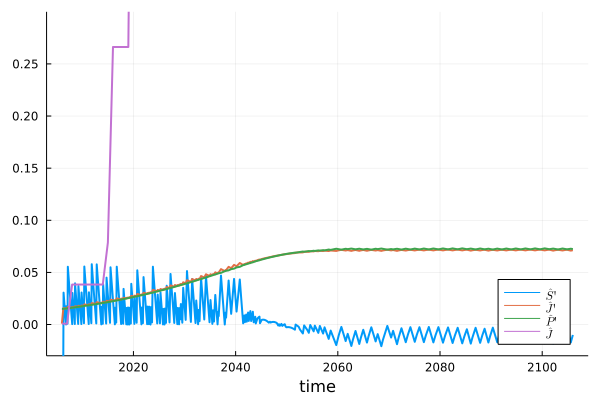

In [7]:
capacity_in_operation = sol[1,:]
population = sol[2,:]
energy_demand = population .* params.energy_per_citizen
energy_security = capacity_in_operation ./ energy_demand .- 1

norm_energy_security = normalize(energy_security)
norm_capacity_in_operation = normalize(capacity_in_operation)
norm_population = normalize(population)
norm_obs_capacity_in_operation = normalize(df_energy.capacity_in_operation)

plot(
    df_energy.Periods[1] .+ sol.t,
    [norm_energy_security, norm_capacity_in_operation, norm_population],
    label=[L"\hat{{\rm S}}'" L"\hat{{\rm J}}'" L"\hat{{\rm P}}'"],
    lw=2,
    xlabel="time",
    legend=:bottomright,
    ylims=(-0.03, 0.3),
)


plot!(
    df_energy.Periods,
    norm_obs_capacity_in_operation .- abs(norm_obs_capacity_in_operation[1] - norm_capacity_in_operation[1]),
    label=L"\hat{{\rm J}}",
    lw=2,
)

# 2. Complex Power Security Model

**Stocks:** Population, Capacity in Operation, Capital Invested

TODO: Improve supply & demand

<img src="EnrgySys_WindFarm_complex.drawio.png" alt="Drawing" style="width: 800px;"/>

### 2.1 Definition of terminology 

**wholesale_price:** Is the cost a wholesaler or distributor pays a manufacturer for their goods. It is based on the total supply cost and on the energy demand/production ratio.

**roic:** Return on invested capital (ROIC) is the amount of money a company makes that is above the average cost it pays for its debt and equity capital.

**nop:** Net operating profit (NOP) is a company's after-tax operating profit for all investors, including shareholders and debt holders.

**energy_security:** Is the percentage by which capacity exceeds market demand. The higher this surplus, the lower prices fall. A negative value indicates a shortage, leading to high prices. Therefore it indicates the *energy security* as used in [5] and *surplus or shortfalls* in [].

**adjustment_factor:** Is the overhead expenses factor; its value ranges from 1.2 to 1.4 depending on the energy resource, which is an important factor in matching supply with demand. Overhead expenses are all costs on the income statement except for direct labor, direct materials, and direct expenses. Overhead expenses include accounting fees, advertising, insurance, interest, legal fees, labor burden, rent, repairs, supplies, taxes, telephone bills, travel expenditures, and utilities.

**investment_per_wh:** Includes production costs (variable and fixed costs).

**energy_demand:** Based on the desired resource production, which we have assumed to equal historical production. Gross production is the production including own use, net production is the production excluding own use. Own use is the electricity that is used in electricity output. In [9] the total primary energy demand is computed as the product of the following factors: population × GDP (gross domestic product) per year per capita × primary energy per unit GDP or, in terms of units, Energy Demand/yr = P * GDP/yr/P * Energy/GDP.

**backup_power_cost:** Some renewable energy plants depend on variable sources, which creates the necessety for backup power to tackle the inherent intermittency problem. The backup power value is 25,000.0 Euro/GWh, which is in line with the additional cost of balancing RE supply/demand (25 Euro/MWh) that is used in Blakers et al. [4].

**capex:** The money an organization or corporate entity spends to buy, maintain, or improve its fixed assets, such as buildings, vehicles, equipment, or land. LCOE = CAPEX + OPEX.

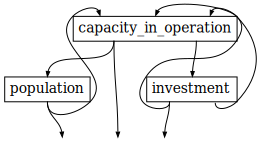

In [8]:
DWD_OffshoreWindEnergy = WiringDiagram(
    [], [:capacity_in_operation, :population, :investment],
)
box_cio = add_box!(DWD_OffshoreWindEnergy, Box(:capacity_in_operation, [:pop, :euro, :euro], [:wh, :wh]))
box_pop = add_box!(DWD_OffshoreWindEnergy, Box(:population, [:wh], [:pop]))
box_inv = add_box!(DWD_OffshoreWindEnergy, Box(:investment, [:wh], [:euro, :euro]))

box_in = input_id(DWD_OffshoreWindEnergy)
box_out = output_id(DWD_OffshoreWindEnergy)
add_wires!(DWD_OffshoreWindEnergy, Pair[        
    # internal
    (box_cio, 1) => (box_pop, 1),
    (box_pop, 1) => (box_cio, 1),

    (box_inv, 1) => (box_cio, 2),
    (box_inv, 2) => (box_cio, 3),
    (box_cio, 2) => (box_inv, 1),

    # net output
    (box_cio, 1) => (box_out, 2),
    (box_pop, 1) => (box_out, 1),
    (box_inv, 1) => (box_out, 3),
])

to_graphviz(DWD_OffshoreWindEnergy)

In [9]:
dt_cio = function(u, x, p, t)
    # Stock
    capacity_in_operation = u[1]  #[d(Wh)/dt]
    # Exogenous variables
    population = x[1]
    investment = x[2]  #[Euro]
    depreciation = x[3]  #[d(Euro)/dt]
    # Flow
    energy_demand = population * p.energy_per_citizen  #[Wh]
    energy_security = capacity_in_operation / energy_demand - 1
    investment_per_wh = investment / capacity_in_operation #+ backup_power_cost  #[d(Euro)/d(Wh)]
    price_per_wh = p.adjustment_factor * investment_per_wh * (energy_demand/capacity_in_operation) + (energy_security/10)^3  #[Euro/Wh] [3]
    supply = capacity_in_operation  #[d(Wh)/dt]
    net_profit_per_watthour = price_per_wh - investment_per_wh  #[d(Euro)/d(Wh)]
    nop = (supply * net_profit_per_watthour) - depreciation  #[d(Euro)/dt]
    roic = nop / investment  #[-] [3]
    investment_approved = max(0, roic-p.min_invest) > 0 ? roic : 0  #[-] [3]
    increase_rate_needed = energy_security > 0 ? p.enesec_impact_on_cio.surplus : p.enesec_impact_on_cio.shortfall  #[-]
    increase_rate_possible = max( (p.energy_of_total_area-capacity_in_operation) / (p.construction_delay), 0)  #[d(Wh)/dt]
    increase_rate = increase_rate_needed * increase_rate_possible #* investment_approved  #[d(Wh)/dt]
    loss_rate = capacity_in_operation / p.life_expectancy_of_turbine  #[d(Wh)/dt]
    #println(net_profit_per_watthour)
    return [increase_rate - loss_rate, increase_rate - loss_rate]
end;

dt_pop = function(u, x, p, t)
    # Stock
    population = u[1]  #[-]
    # Exogenous variables
    capacity_in_operation = x[1]
    # Flow
    energy_demand = population * p.energy_per_citizen  #[Wh]
    energy_security = capacity_in_operation / energy_demand - 1  #[-]
    energy_security_impact = energy_security > 0 ? p.enesec_impact_on_pop.surplus : p.enesec_impact_on_pop.shortfall  #[-]
    birth_rate = population * p.birth_fraction * energy_security_impact #[1/yr]
    death_rate = population / p.life_expectancy_of_human  #[1/yr]
    return [birth_rate - death_rate]
end;

dt_inv = function(u, x, p, t)
    # Stock
    investment = u[1]
    # Exogenous variables
    capacity_increase_rate = x[1]  #[d(Wh)/dt]
    # Flow
    expenditure = p.lcoe * capacity_increase_rate  #[d(Euro)/dt] captial expenditure costs
    depreciation = investment / p.life_expectancy_of_turbine  #[d(Euro)/dt] capital depreciation
    #println(expenditure/depreciation)
    return [expenditure - depreciation, depreciation]
end;

machine_cio = ContinuousMachine{Float64}(3,2,2, dt_cio, (u, p, t)->u)
machine_pop = ContinuousMachine{Float64}(1,1,1, dt_pop, (u, p, t)->u)
machine_inv = ContinuousMachine{Float64}(1,2,2, dt_inv, (u, p, t)->u)

Model_OffshoreWindEnergy = oapply(
    DWD_OffshoreWindEnergy,
    Dict(
        :capacity_in_operation => machine_cio,
        :population => machine_pop,
        :investment => machine_inv,
    )
)

ContinuousMachine(ℝ^5 × ℝ^0 → ℝ^5)

In [10]:
dt_cio(
    [df_energy.capacity_in_operation[1]],
    [16.35*1e6, 300*1e6, 300*1e6/20],
    params,
    0,
)

LoadError: type LArray{Any, 1, Vector{Any}, (:energy_per_turbine, :energy_of_total_area, :enesec_impact_on_cio, :enesec_impact_on_pop, :life_expectancy_of_turbine, :construction_delay, :life_expectancy_of_human, :birth_fraction, :energy_per_citizen)} has no field adjustment_factor

In [11]:
energy_of_each_area = LVector(  # [2]
    Borssele = (731.5 + 752 + 19) * 1e6,  #[W]
    HollandseKust_zuid = (129 + 760 + 760) * 1e6,  #[W]
    HollandseKust_noord = (759 + 120 + 108) * 1e6,  #[W]
    HollandseKust_west = 1400 * 1e6,  #[W]
    IjmuidenVer = 4000 * 1e6,  #[W]
    Waddeneilanden = 700 * 1e6,  #[W]
)

params = LVector(
    energy_per_turbine=9.5*1e6*60^2,  #[Wh] [2]
    energy_of_total_area=sum(energy_of_each_area),  #[Wh]
    enesec_impact_on_cio=LVector(surplus=0.0, shortfall=1.5),  #[-]
    enesec_impact_on_pop=LVector(surplus=2.0, shortfall=0.0),  #[-]
    life_expectancy_of_turbine=20,  #[yr]=20
    construction_delay=2,  #[yr] [3]=2
    min_invest=0.1,  #[-] [3]
    adjustment_factor=1.4,  #[%] [3]
    capex=11e6,  #[Euro/Wh]
    opex=11e6,  #[Euro/Wh]
    lcoe=10,  #[Euro/Wh]
    life_expectancy_of_human=81,  #[yr] [6]=81
    birth_fraction=0.028,  #[-] [7]=0.0098
    energy_per_citizen=1070*1e3/(365*24),  #[Wh] [8]
);

In [12]:
u0 = [df_energy.capacity_in_operation[1], 0, 16.35*1e6, 300*1e6, 300*1e6/20];  # [energy, population, investment [10]] at 2006
tspan = (0.0, 60.0);

prob = ODEProblem(Model_OffshoreWindEnergy, u0, tspan, params);
sol = solve(prob, Tsit5());

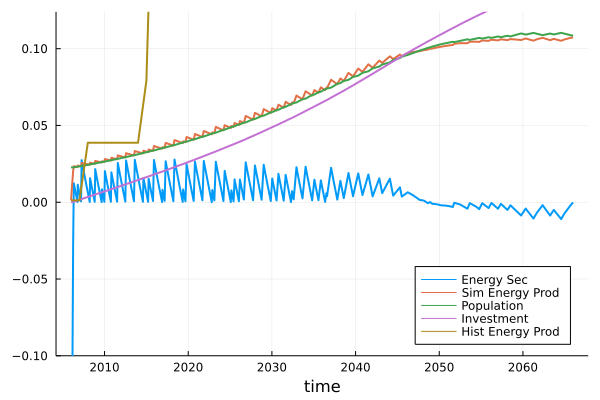

In [13]:
capacity_in_operation = sol[1,:]
population = sol[3,:]
investment = sol[4,:]

energy_demand = population .* params.energy_per_citizen
energy_security = capacity_in_operation ./ energy_demand .- 1

norm_energy_security = normalize(energy_security)
norm_capacity_in_operation = normalize(capacity_in_operation)
norm_population = normalize(population)
norm_investment = normalize(investment)
norm_obs_capacity_in_operation = normalize(df_energy.capacity_in_operation)

plot(
    df_energy.Periods[1] .+ sol.t,
    [norm_energy_security, norm_capacity_in_operation, norm_population, norm_investment],
    #label=[L"\hat{{\rm S}}'" L"\hat{{\rm J}}'" L"\hat{{\rm P}}'" L"\hat{{\rm I}}'"],
    label=["Energy Sec" "Sim Energy Prod" "Population" "Investment"],
    lw=2,
    xlabel="time",
    legend=:bottomright,
    ylims=(-0.1, 0.124),
)

plot!(
    df_energy.Periods,
    norm_obs_capacity_in_operation .- abs(norm_obs_capacity_in_operation[1] - norm_capacity_in_operation[1]),
    label="Hist Energy Prod",
    lw=2,
)

# Bibliography

[1] https://www.rijksoverheid.nl/onderwerpen/duurzame-energie/windenergie-op-zee

[2] https://windopzee.nl/onderwerpen/wind-zee/landingspagina/windpark

[3] https://www.mdpi.com/2076-3417/10/1/134

[4] https://doi.org/10.1016/j.energy.2017.05.168

[5] http://link.springer.com/10.1007/978-981-10-2045-2

[6] https://www.volksgezondheidenzorg.info/onderwerp/levensverwachting/cijfers-context/huidige-situatie

[7] https://www.volksgezondheidenzorg.info/onderwerp/bevolking/cijfers-context/geboorte#node-totaal-aantal-geboorten

[8] https://www.cbs.nl/nl-nl/achtergrond/2018/14/energieverbruik-van-particuliere-huishoudens

[9] https://www.wiley.com/en-gb/Environmental+Modelling%3A+Finding+Simplicity+in+Complexity%2C+2nd+Edition-p-9780470749111https://www.wiley.com/en-gb/Environmental+Modelling%3A+Finding+Simplicity+in+Complexity%2C+2nd+Edition-p-9780470749111

[10] https://en.wikipedia.org/wiki/Wind_power_in_the_Netherlands#Offshore_wind_powerhttps://en.wikipedia.org/wiki/Wind_power_in_the_Netherlands#Offshore_wind_power

[11] https://www.mdpi.com/2071-1050/6/5/2601https://www.mdpi.com/2071-1050/6/5/2601

[12] https://link.springer.com/book/10.1007/978-3-319-24829-5https://link.springer.com/book/10.1007/978-3-319-24829-5